Alexandre CARRE*, Marvin LEROUSSEAU, Enzo BATTISTELLA <img align="right" width="400" height="40" src="images/epu_ia_logo.png"> <br> *alexandre.carre@gustaveroussy.fr (Notebook conception) <br> marvin.lerousseau@gustaveroussy.fr (Notebook revision) <br> enzo.battistella@gustaveroussy.fr (Notebook revision)

# TP2: FEATURES EXTRACTION-VISUALIZATION

In this notebook, you will learn how to extract radiomics features and visualize the important characteristics of the Dataset. First, download necessary materials for the afternoon practical sessions.

In [3]:
##!git clone https://github.com/RRouhi/EPU-IA-2021.git
##%cd EPU-IA-2021/

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Master_Class/ML/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Master_Class/ML


### Installation of dependencies

In [4]:
!pip install pyradiomics seaborn SimpleITK numpy pandas

     |████████████████████████████████| 188 kB 5.1 MB/s 
     |████████████████████████████████| 48.4 MB 5.2 kB/s 
     |████████████████████████████████| 109 kB 44.1 MB/s 
     |████████████████████████████████| 546 kB 46.3 MB/s 


## Step 1: Radiomics features extraction

#### import radiomics toolbox

In [5]:
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

### 1) Setting up data

We will load 2 patients from the BratS dataset (Images and segmentations of brain tumors). The radiomics package will be used to extract a set of features, and the "signatures" will be compared.

In the following, the data is returned in the sitk format. Two test cases will be loaded and and saved.

In [6]:
import os
import glob
import SimpleITK as sitk


def load_nii_volume_as_array(filename, with_header=False):
    """
    load nifty image into numpy array [z,y,x] axis order
    The output array shape is like [Depth, Height, Width]
    :param filename: the input file name, should be *.nii or *.nii.gz
    :param with_header: return header information
    :return: a numpy data array or numpy data array with header if set to True
    """
    img = sitk.ReadImage(filename)
    data = sitk.GetArrayFromImage(img)

    if with_header:
        origin, spacing, direction = img.GetOrigin(), img.GetSpacing(), img.GetDirection()
        return data, (origin, spacing, direction)
    else:
        return data

    
def set_header_information(array, header):
    """
    Function to set header information to an array.
    :param array: array to set the header
    :param header: header information will be a tuple with (origin, spacing, direction)
    :return: an image in sitk format
    """
    img = sitk.GetImageFromArray(array)
    img.SetOrigin(header[0])
    img.SetSpacing(header[1])
    img.SetDirection(header[2])
    return img


# function to process one subject data and return output path
def process_one_subject(src, count, image_type):
    """
    Function to read one subject data from the general input directory specifying by the count number and image_type
    :param src: general input directory of all data
    :param count: patient to be read (same order as the glob function walk in the path)
    :param image_type: specify the image type to be read, can be 't1ce', 't1', 'flair', 't2', 'seg'
    :return: a dict for the 'seg' with key as type of seg and value as nD array. For image a nD array
    """
    # add check range of count (depend of numbers of samples)
    files = glob.glob(os.path.join(src, '**/*{}.nii.gz'.format(image_type)), recursive=True)
    k = (len(files) - count) - 1
    file = files[k]
    print('Processing---', os.path.basename(file))

    if any(x in image_type.lower() for x in ['t1ce', 't1', 'flair', 't2']):
        normalized = zscore_normalize(file)
        return normalized

    if 'seg' in image_type.lower():
        label_full, label_nec, label_core, label_et = [], [], [], []
        for label_num in [1, 2, 4, 5]:
            img, header = load_nii_volume_as_array(file, with_header=True)
            if label_num == 5:
                img[img != 0] = 1  # Region 1 => 1+2+3+4 complete tumor
                label_full = set_header_information(img, header)
            if label_num == 1:
                img[img != 1] = 0  # only left necrosis
                label_nec = set_header_information(img, header)
            if label_num == 2:
                img[img == 2] = 0  # turn edema to 0
                img[img != 0] = 1  # only keep necrosis, ET, NET = Tumor core
                label_core = set_header_information(img, header)
            if label_num == 4:
                img[img != 4] = 0  # only left ET
                img[img == 4] = 1
                label_et = set_header_information(img, header)
        return {'label_full': label_full, 'label_nec': label_nec,
                'label_core': label_core, 'label_et': label_et}


def zscore_normalize(img_path, mask=None):
    """
    Function to Z-Score normalize an image from an image filepath. It will normalize the target 
    image by subtracting the mean of the whole brain and dividing by the standard deviation.
    :param img_path: target MR brain image path
    :param mask: brain mask path for img
    :return: Normalized image in sitk format
    """
    img_data, header = load_nii_volume_as_array(img_path, with_header=True)
    if mask is not None and isinstance(mask, str):
        mask_data = load_nii_volume_as_array(mask, with_header=False)
    elif mask == 'nomask':
        mask_data = img_data == img_data
    else:
        mask_data = img_data > img_data.mean()
    logical_mask = mask_data == 1  # force the mask to be logical type
    mean = img_data[logical_mask].mean()
    std = img_data[logical_mask].std()
    normalized_data = (img_data - mean) / std
    normalized = set_header_information(normalized_data, header)
    return normalized

**Exercice:** Now load images from two patients with all their respective segmentations and apply normalization to MRI images. Then, save these new images. As a reminder the images of the BratS dataset have already been processed excluding from normalization. For your output filename, make sure to have an unique ID in the filename with the sequence name. 

Example :
- For MRI modalities: id_modality_normalize.nii.gz (patient1_t1ce_normalize.nii.gz)
- For Segmentations : id_seg_segtype.nii.gz (patient1_seg_nec.nii.gz)

In [1]:
#@title Exercise 1 {display-mode: "form"}
# %load solutions_exercices/2patients.py

src = './data/preprocessed/'
patient1_t1 = process_one_subject(src, count=0, image_type='t1')
patient1_t1_normalize_path = 'patient1_t1_normalize.nii.gz'
sitk.WriteImage(patient1_t1, patient1_t1_normalize_path)

patient1_t1ce = process_one_subject(src, count=0, image_type='t1ce')
patient1_tce1_normalize_path = 'patient1_t1ce_normalize.nii.gz'
sitk.WriteImage('''CompleteHere''', patient1_tce1_normalize_path)

patient1_t2 = process_one_subject(src, count=0, image_type='t2')
patient1_t2_normalize_path = 'patient1_t2_normalize.nii.gz'
sitk.WriteImage(patient1_t2, '''CompleteHere''')

patient1_flair = process_one_subject(src, count=0, image_type='flair')
patient1_flair_normalize_path = 'patient1_flair_normalize.nii.gz'
sitk.WriteImage('''CompleteHere''', '''CompleteHere''')

patient1_segmentations = '''CompleteHere'''(src, count=0, image_type='seg') # return a dict with {label_full, label_nec, label_core, label_et}
patient1_seg_label_full_path = 'patient1_seg_label_full.nii.gz'
sitk.WriteImage(patient1_segmentations['label_full'], '''CompleteHere''')
patient1_seg_label_nec_path = 'patient1_seg_label_nec.nii.gz'
sitk.WriteImage(patient1_segmentations['label_nec'], '''CompleteHere''')
patient1_seg_label_core_path = 'patient1_seg_label_core.nii.gz'
sitk.WriteImage(patient1_segmentations['label_core'], '''CompleteHere''')
patient1_seg_label_et_path = 'patient1_seg_label_et.nii.gz'
sitk.WriteImage(patient1_segmentations['label_et'], '''CompleteHere''')


patient2_t1 = '''CompleteHere'''(src, count=1, image_type='t1')
patient2_t1_normalize_path = 'patient2_t1_normalize.nii.gz'
sitk.WriteImage('''CompleteHere''', '''CompleteHere''')

patient2_t1ce = process_one_subject(src, count=1, image_type='t1ce')
patient2_tce1_normalize_path = 'patient2_t1ce_normalize.nii.gz'
sitk.WriteImage('''CompleteHere''', '''CompleteHere''')

patient2_t2 = process_one_subject(src, count=1, image_type='t2')
patient2_t2_normalize_path = 'patient2_t2_normalize.nii.gz'
sitk.WriteImage('''CompleteHere''', '''CompleteHere''')

patient2_flair = process_one_subject(src, count=1, image_type='flair')
patient2_flair_normalize_path = 'patient2_flair_normalize.nii.gz'
sitk.WriteImage(patient2_flair, '''CompleteHere''')

patient2_segmentations = process_one_subject(src, count=1, image_type='seg')
patient2_seg_label_full_path = 'patient2_seg_label_full.nii.gz'
sitk.WriteImage(patient2_segmentations['label_full'], '''CompleteHere''')
patient2_seg_label_nec_path = 'patient2_seg_label_nec.nii.gz'
sitk.WriteImage(patient2_segmentations['label_nec'], '''CompleteHere''')
patient2_seg_label_core_path = 'patient2_seg_label_core.nii.gz'
sitk.WriteImage(patient2_segmentations['label_core'], '''CompleteHere''')
patient2_seg_label_et_path = 'patient2_seg_label_et.nii.gz'
sitk.WriteImage(patient2_segmentations['label_et'], '''CompleteHere''')


NameError: ignored

In [7]:

#@title Solution 1 {display-mode: "form"}
# %load solutions_exercices/2patients.py

src = './data/preprocessed/'
patient1_t1 = process_one_subject(src, count=0, image_type='t1')
patient1_t1_normalize_path = 'patient1_t1_normalize.nii.gz'
sitk.WriteImage(patient1_t1, patient1_t1_normalize_path)

patient1_t1ce = process_one_subject(src, count=0, image_type='t1ce')
patient1_tce1_normalize_path = 'patient1_t1ce_normalize.nii.gz'
sitk.WriteImage(patient1_t1ce, patient1_tce1_normalize_path)

patient1_t2 = process_one_subject(src, count=0, image_type='t2')
patient1_t2_normalize_path = 'patient1_t2_normalize.nii.gz'
sitk.WriteImage(patient1_t2, patient1_t2_normalize_path)

patient1_flair = process_one_subject(src, count=0, image_type='flair')
patient1_flair_normalize_path = 'patient1_flair_normalize.nii.gz'
sitk.WriteImage(patient1_flair, patient1_flair_normalize_path)

patient1_segmentations = process_one_subject(src, count=0, image_type='seg') # return a dict with {label_full, label_nec, label_core, label_et}
patient1_seg_label_full_path = 'patient1_seg_label_full.nii.gz'
sitk.WriteImage(patient1_segmentations['label_full'], patient1_seg_label_full_path)
patient1_seg_label_nec_path = 'patient1_seg_label_nec.nii.gz'
sitk.WriteImage(patient1_segmentations['label_nec'], patient1_seg_label_nec_path)
patient1_seg_label_core_path = 'patient1_seg_label_core.nii.gz'
sitk.WriteImage(patient1_segmentations['label_core'], patient1_seg_label_core_path)
patient1_seg_label_et_path = 'patient1_seg_label_et.nii.gz'
sitk.WriteImage(patient1_segmentations['label_et'], patient1_seg_label_et_path)


patient2_t1 = process_one_subject(src, count=1, image_type='t1')
patient2_t1_normalize_path = 'patient2_t1_normalize.nii.gz'
sitk.WriteImage(patient2_t1, patient2_t1_normalize_path)

patient2_t1ce = process_one_subject(src, count=1, image_type='t1ce')
patient2_tce1_normalize_path = 'patient2_t1ce_normalize.nii.gz'
sitk.WriteImage(patient2_t1ce, patient2_tce1_normalize_path)

patient2_t2 = process_one_subject(src, count=1, image_type='t2')
patient2_t2_normalize_path = 'patient2_t2_normalize.nii.gz'
sitk.WriteImage(patient2_t2, patient2_t2_normalize_path)

patient2_flair = process_one_subject(src, count=1, image_type='flair')
patient2_flair_normalize_path = 'patient2_flair_normalize.nii.gz'
sitk.WriteImage(patient2_flair, patient2_flair_normalize_path)

patient2_segmentations = process_one_subject(src, count=1, image_type='seg')
patient2_seg_label_full_path = 'patient2_seg_label_full.nii.gz'
sitk.WriteImage(patient2_segmentations['label_full'], patient2_seg_label_full_path)
patient2_seg_label_nec_path = 'patient2_seg_label_nec.nii.gz'
sitk.WriteImage(patient2_segmentations['label_nec'], patient2_seg_label_nec_path)
patient2_seg_label_core_path = 'patient2_seg_label_core.nii.gz'
sitk.WriteImage(patient2_segmentations['label_core'], patient2_seg_label_core_path)
patient2_seg_label_et_path = 'patient2_seg_label_et.nii.gz'
sitk.WriteImage(patient2_segmentations['label_et'], patient2_seg_label_et_path)

Processing--- TCGA-CS-6188_2001.08.12_t1.nii.gz
Processing--- TCGA-CS-6188_2001.08.12_t1ce.nii.gz
Processing--- TCGA-CS-6188_2001.08.12_t2.nii.gz
Processing--- TCGA-CS-6188_2001.08.12_flair.nii.gz
Processing--- TCGA-CS-6188_2001.08.12_seg.nii.gz
Processing--- TCGA-CS-6186_2000.06.01_t1.nii.gz
Processing--- TCGA-CS-6186_2000.06.01_t1ce.nii.gz
Processing--- TCGA-CS-6186_2000.06.01_t2.nii.gz
Processing--- TCGA-CS-6186_2000.06.01_flair.nii.gz
Processing--- TCGA-CS-6186_2000.06.01_seg.nii.gz


### 2) Start the extraction

Now that we have our input, we need to define the parameters and instantiate the extractor.

#### We use the default setting of the extractor.

In [8]:

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


###  Extract features¶

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [9]:
imagePath = patient1_t1_normalize_path
maskPath = patient1_seg_label_full_path

result = extractor.execute(imagePath, maskPath)
print(result)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'), ('diagnostics_Versions_Numpy', '1.19.5'), ('diagnostics_Versions_SimpleITK', '2.1.1'), ('diagnostics_Versions_PyWavelet', '1.1.1'), ('diagnostics_Versions_Python', '3.7.12'), ('diagnostics_Configuration_Settings', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}), ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}), ('diagnostics_Image-original_Hash', '9b254c88bd7c5dce806b5c3b096441635b242bdc'), ('diagnostics_Image-original_Dimensionality', '3D'), ('diagnostics_Image-original_Spacing', (1.0, 1.0, 1.0)), ('diagnostics_Image-original_Size', (240, 240, 155)), ('diagnostics_Image-original_Mean', -3.2388073481968083), ('diagnostics_Image

As you may have already seen, Pyradiomics returns an ordered dict that is visually not very pleasant. We can then turn this result into a pandas format. The keys in the dictionary will be used as the index (labels for the rows), with the values of the features as the values in the rows.

In [10]:
import pandas as pd 

df = pd.Series(result)

In [11]:
pd.set_option('display.max_rows', None)
print(df)

diagnostics_Versions_PyRadiomics                                                                 v3.0.1
diagnostics_Versions_Numpy                                                                       1.19.5
diagnostics_Versions_SimpleITK                                                                    2.1.1
diagnostics_Versions_PyWavelet                                                                    1.1.1
diagnostics_Versions_Python                                                                      3.7.12
diagnostics_Configuration_Settings                    {'minimumROIDimensions': 2, 'minimumROISize': ...
diagnostics_Configuration_EnabledImageTypes                                            {'Original': {}}
diagnostics_Image-original_Hash                                9b254c88bd7c5dce806b5c3b096441635b242bdc
diagnostics_Image-original_Dimensionality                                                            3D
diagnostics_Image-original_Spacing                              

Now we will use a loop to extract a set of features for our two patients with all their segmentations

In [12]:
# The idea is to loop over image and associated segmentations
# We choose to create a dataframe who associated both

from IPython.display import display
import pandas as pd

patient1_segmentations_path = [patient1_seg_label_full_path, patient1_seg_label_nec_path, patient1_seg_label_core_path, patient1_seg_label_et_path]
patient2_segmentations_path = [patient2_seg_label_full_path, patient2_seg_label_nec_path, patient2_seg_label_core_path, patient2_seg_label_et_path]
patient1_images_path = [patient1_t1_normalize_path, patient1_tce1_normalize_path, patient1_t2_normalize_path, patient1_flair_normalize_path]
patient2_images_path = [patient2_t1_normalize_path, patient2_tce1_normalize_path, patient2_t2_normalize_path, patient2_flair_normalize_path]

# For a segmentation, we have 4 MRI sequences

segmentations  = [item for item in patient1_segmentations_path for i in range(4)] + [item for item in patient2_segmentations_path for i in range(4)]
images = patient1_images_path * 4 + patient2_images_path * 4

# Now we construct a DataFrame from our two list
data = {'Image':  images,
        'Segmentation': segmentations,
        }

database_df = pd.DataFrame (data, columns = data.keys())
display(database_df)

,Image,Segmentation
0,patient1_t1_normalize.nii.gz,patient1_seg_label_full.nii.gz
1,patient1_t1ce_normalize.nii.gz,patient1_seg_label_full.nii.gz
2,patient1_t2_normalize.nii.gz,patient1_seg_label_full.nii.gz
3,patient1_flair_normalize.nii.gz,patient1_seg_label_full.nii.gz
4,patient1_t1_normalize.nii.gz,patient1_seg_label_nec.nii.gz
5,patient1_t1ce_normalize.nii.gz,patient1_seg_label_nec.nii.gz
6,patient1_t2_normalize.nii.gz,patient1_seg_label_nec.nii.gz
7,patient1_flair_normalize.nii.gz,patient1_seg_label_nec.nii.gz
8,patient1_t1_normalize.nii.gz,patient1_seg_label_core.nii.gz
9,patient1_t1ce_normalize.nii.gz,patient1_seg_label_core.nii.gz


In [13]:
# We construct the loop to extract features from our Database generated DataFrame
from radiomics import featureextractor

paramPath = os.path.join('exampleSettings', 'Params.yaml')
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

results_extraction = pd.DataFrame()
for row_idx, row in database_df.iterrows():
    print('process:'  '   ----   ' 'Image: ', row['Image'], ' Segmentation: ', row['Segmentation'])
    result_extraction = pd.Series(extractor.execute(row['Image'], row['Segmentation']))
    feature_vector = (pd.Series(row)).append(result_extraction)
    feature_vector.name = row_idx
    results_extraction = results_extraction.join(feature_vector, how='outer')
    
# Transpose DataFrame to have one row by analysis
results_extraction = results_extraction.T

process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz
process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz
process:   ----   Image:  patient1_t2_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz
process:   ----   Image:  patient1_flair_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz
process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz
process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz
process:   ----   Image:  patient1_t2_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz
process:   ----   Image:  patient1_flair_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz
process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_core.nii.gz
process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  pat

In [14]:
# One row per image/segmentation, features ares columns
from IPython.display import display

display(results_extraction)

,Image,Segmentation,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,patient1_t1_normalize.nii.gz,patient1_seg_label_full.nii.gz,v3.0.1,1.19.5,2.1.1,1.1.1,3.7.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},9b254c88bd7c5dce806b5c3b096441635b242bdc,3D,"(1.0, 1.0, 1.0)","(240, 240, 155)",-3.23881,-3.94691,10.8797,854e13e7b95928c8268a22517a7a8b3d1eb2d7c5,"(1.0, 1.0, 1.0)","(240, 240, 155)","(134, 148, 40, 52, 68, 70)",30073,21,"(163.4712865360955, 182.95750340837296, 75.827...","(163.4712865360955, -56.04249659162704, 75.827...",0.808885,0.377958,21.6676,57.3281,69.72087205421343,65.12296062065974,79.64923100695951,84.581321815162,29775.791666666668,46.3719,0.40144206969101914,11572.755724454999,0.38866324207293673,30073,-0.0071202838352694055,1.2534129661686686,...,21.262538204944352,0.4864580996228712,4.324207395427617,695.4460686661334,0.12764085262596422,0.1752888484175685,42.91075519529453,0.32741216892968605,0.7437646901045394,0.22332403863597264,34.89473684210526,0.6121883656509696,0.19390581717451522,1.7894736842105263,12713757.94736842,50702562.368421055,3216556.8421052634,0.8026315789473685,5.385964912280702,0.09449061249615266,0.2905188199011448,0.5876169602193619,0.21624428482159

Now, you have an example of the extracted features corresponding with the two patients and their respective modalities and also segmentations.

### Signatures comparison

Now, let's compare the signatures for our two patients...

#### Prepare for plotting

Because we'd like to plot the feature vectors, create numpy arrays for features starting with original_ (excluding meta-features).

In [15]:
# Adding some cleaning in the generated dataframe
patient = results_extraction['Image'].str.split('_').str[0]
sequence = results_extraction['Image'].str.split('_').str[1]
segtype = results_extraction['Segmentation'].str.split('_').str[-1].str.split('.').str[0]
features_columns = [col for col in results_extraction if col.startswith('original')]
dataframe_cleaned = results_extraction[features_columns] 
dataframe_cleaned.insert(0, 'patient', patient)
dataframe_cleaned.insert(1, 'sequence', sequence)
dataframe_cleaned.insert(2, 'segmentation', segtype)

display(dataframe_cleaned)

# Now you can easily select a line of set of features for a patient sequence for a specific segmentations: ie

features_p1_t1_full =  dataframe_cleaned.iloc[0, 3:].to_numpy()
features_p2_t1_full =  dataframe_cleaned.iloc[16, 3:].to_numpy()


# Help iloc[row_idx, columns_idx]

,patient,sequence,segmentation,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,patient1,t1,full,0.808885,0.377958,21.6676,57.3281,69.72087205421343,65.12296062065974,79.64923100695951,84.581321815162,29775.791666666668,46.3719,0.40144206969101914,11572.755724454999,0.38866324207293673,30073,-0.0071202838352694055,1.2534129661686686,33031.506181972254,0.47295691345861357,0.636194181027187,17.645262595713458,1.9951266941485872,0.5072319478399978,0.5307012269439779,0.6675351385769183,-3.902112823153922,5.897239517302509,0.2638926195213857,1.0480350602497963,-3.4810819648344276,33031.506181972254,0.8179973571862309,0.8167336952329503,3.7254818726074683,1.9182537196680882,0.6243955157770713,-0.35467557574303854,0.24159497086495416,...,21.262538204944352,0.4864580996228712,4.324207395427617,695.4460686661334,0.12764085262596422,0.1752888484175685,42.91075519529453,0.32741216892968605,0.7437646901045394,0.22332403863597264,34.89473684210526,0.6121883656509696,0.19390581717451522,1.7894736842105263,12713757.94736842,50702562.368421055,3216556.8421052634,0.8026315789473685,5.385964912280702,0.09449061249615266,0.2905188199011448,0.5876169602193619,0.21624428482159058,4.652918418266811,0.0018953878894689589,12435399.889812248,3.5856983233921946,6907.156153360157,0.22967965129385684,34.77514003768188,24599.634522661523,0.09100132

**Exercice:** Plot the two feature vectors and the difference. Feature values have a wide range of magnitudes and will be plotted on a log scale. You can have fun and change the input modality or the segmentation type.
Plot will be composed of three subplot, first is features from patient1 from a modality_type1 for segtype1. Second is features from patient2 from a modality_type2 for segtype2. Third subplot is the difference between the two features vectors.

In [ ]:
#@title Exercise 2 {display-mode: "form"}
# %load solutions_exercices/plot_features_vector.py


import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True, figsize=(20, 10))

axes[0].plot('''CompleteHere''', label='features from patient 1 for the full segmentation in T1 modality', color='red')
axes[0].'''CompleteHere'''(features_p2_t1_full, label='features from patient 2 for the full segmentation in T1 modality', color='green')
axes[0].set_yscale('symlog')
axes[0].set_ylabel('symlog')
axes[0].set_xlabel('feature id')
axes[0].set_xticklabels(features_columns, rotation='vertical')
axes[0].set_title("Features from Patient 1 for the full segmentation in T1 modality")

axes[1].plot('''CompleteHere''' - features_p2_t1_full)
axes[1].set_yscale('symlog')
axes[1].set_ylabel('symlog')
axes[1].set_xlabel('feature id')
axes[1].set_xticks(range(len(features_p1_t1_full)))
axes[1].set_xticklabels('''CompleteHere''', rotation=90)
axes[1].'''CompleteHere'''("Difference")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show();




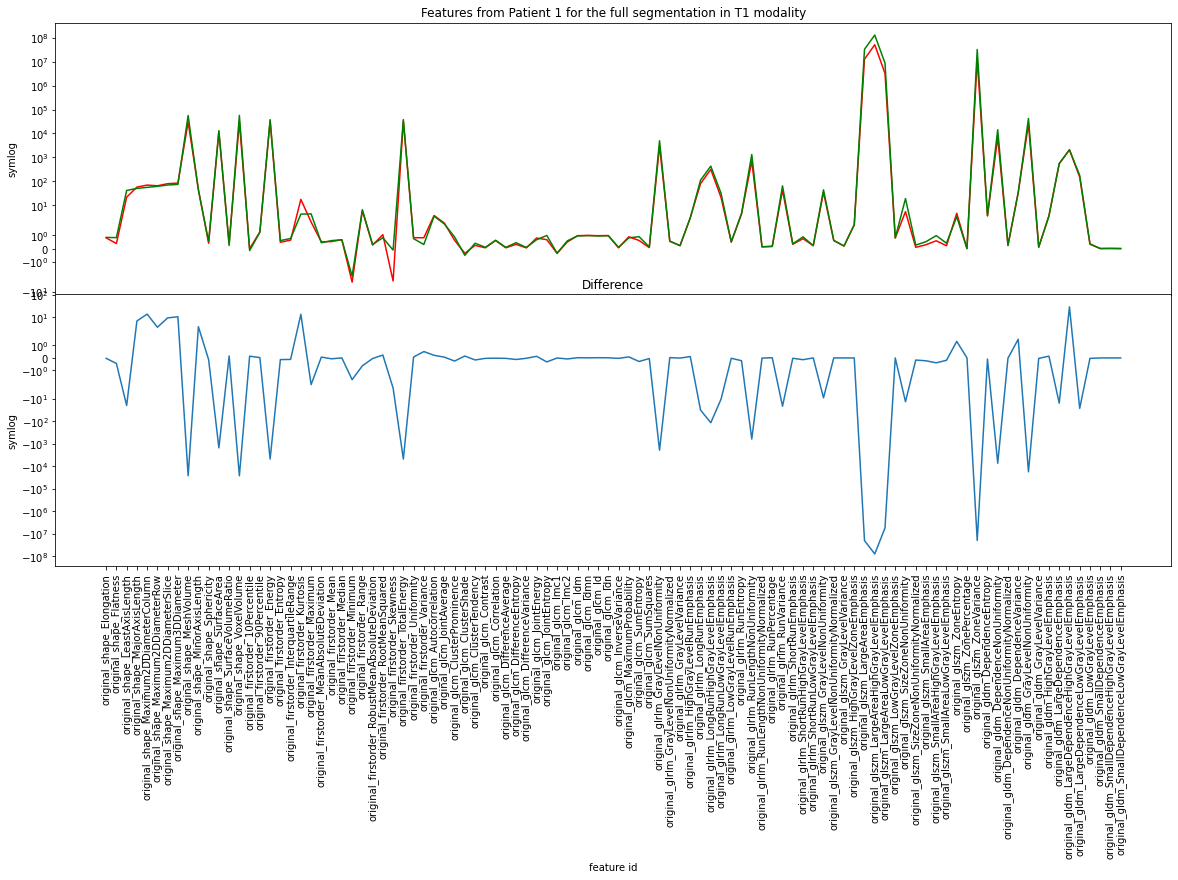

In [ ]:
#@title Solution 2 {display-mode: "form"}
# %load solutions_exercices/plot_features_vector.py


import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True, figsize=(20, 10))

axes[0].plot(features_p1_t1_full, label='features from patient 1 for the full segmentation in T1 modality', color='red')
axes[0].plot(features_p2_t1_full, label='features from patient 2 for the full segmentation in T1 modality', color='green')
axes[0].set_yscale('symlog')
axes[0].set_ylabel('symlog')
axes[0].set_xlabel('feature id')
axes[0].set_xticklabels(features_columns, rotation='vertical')
axes[0].set_title("Features from Patient 1 for the full segmentation in T1 modality")

axes[1].plot(features_p1_t1_full - features_p2_t1_full)
axes[1].set_yscale('symlog')
axes[1].set_ylabel('symlog')
axes[1].set_xlabel('feature id')
axes[1].set_xticks(range(len(features_p1_t1_full)))
axes[1].set_xticklabels(features_columns, rotation=90)
axes[1].set_title("Difference")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show();

## Step 2: Exploring and Visualizing Data

The first step in machine learning is to understand your data, so that you can identify a good target to learn and choose an appropriate learning technique among many possible families of candidates.

The previous work of this notebook has been applied on up to two patients, with already significant time to process all of the data into features. Since our time in this practical session is limited, the features on the entire BraTS dataset has been extracted beforehand and saved into a csv file which should be available locally in _./data/radiomics_analysis_cleaned.csv_. This file contains one row per patient per input modality (T1, T1ce, T2, flair) per type of tumor ROI (4*4=16 rows per patient).

Let's explore the data !

### Load datas

In [ ]:
import pandas as pd
from IPython.display import display

path_dataset = './data/radiomics_analysis_cleaned.csv'

data = pd.read_csv(path_dataset)
display(data)

We can generate a full dataframe which representes all the features for a patient 

In [ ]:
full_features_df = data.pivot_table(index=['patient', 'label'],
                                    columns=['sequence', 'segmentation'],
                                    values=data.columns[4:])
full_features_df.columns = ['_'.join(col).strip() for col in full_features_df.columns.values]
full_features_df.reset_index(level=1, inplace=True)
display(full_features_df)

,label,original_firstorder_10Percentile_flair_core,original_firstorder_10Percentile_flair_et,original_firstorder_10Percentile_flair_full,original_firstorder_10Percentile_flair_nec,original_firstorder_10Percentile_t1_core,original_firstorder_10Percentile_t1_et,original_firstorder_10Percentile_t1_full,original_firstorder_10Percentile_t1_nec,original_firstorder_10Percentile_t1ce_core,original_firstorder_10Percentile_t1ce_et,original_firstorder_10Percentile_t1ce_full,original_firstorder_10Percentile_t1ce_nec,original_firstorder_10Percentile_t2_core,original_firstorder_10Percentile_t2_et,original_firstorder_10Percentile_t2_full,original_firstorder_10Percentile_t2_nec,original_firstorder_90Percentile_flair_core,original_firstorder_90Percentile_flair_et,original_firstorder_90Percentile_flair_full,original_firstorder_90Percentile_flair_nec,original_firstorder_90Percentile_t1_core,original_firstorder_90Percentile_t1_et,original_firstorder_90Percentile_t1_full,original_firstorder_90Percentile_t1_nec,original_firstorder_90Percentile_t1ce_core,original_firstorder_90Percentile_t1ce_et,original_firstorder_90Percentile_t1ce_full,original_firstorder_90Percentile_t1ce_nec,original_firstorder_90Percentile_t2_core,original_firstorder_90Percentile_t2_et,original_firstorder_90Percentile_t2_full,original_firstorder_90Percentile_t2_nec,original_firstorder_Energy_flair_core,original_firstorder_Energy_flair_et,original_firstorder_Energy_flair_full,original_firstorder_Energy_flair_nec,original_firstorder_Energy_t1_core,original_firstorder_Energy_t1_et,original_firstorder_Energy_t1_full,...,original_shape_SurfaceArea_t1ce_core,original_shape_SurfaceArea_t1ce_et,original_shape_SurfaceArea_t1ce_full,original_shape_SurfaceArea_t1ce_nec,original_shape_SurfaceArea_t2_core,original_shape_SurfaceArea_t2_et,original_shape_SurfaceArea_t2_full,original_shape_SurfaceArea_t2_nec,original_shape_SurfaceVolumeRatio_flair_core,original_shape_SurfaceVolumeRatio_flair_et,original_shape_SurfaceVolumeRatio_flair_full,original_shape_SurfaceVolumeRatio_flair_nec,original_shape_SurfaceVolumeRatio_t1_core,original_shape_SurfaceVolumeRatio_t1_et,original_shape_SurfaceVolumeRatio_t1_full,original_shape_SurfaceVolumeRatio_t1_nec,original_shape_SurfaceVolumeRatio_t1ce_core,original_shape_SurfaceVolumeRatio_t1ce_et,original_shape_SurfaceVolumeRatio_t1ce_full,original_shape_SurfaceVolumeRatio_t1ce_nec,original_shape_SurfaceVolumeRatio_t2_core,original_shape_SurfaceVolumeRatio_t2_et,original_shape_SurfaceVolumeRatio_t2_full,original_shape_SurfaceVolumeRatio_t2_nec,original_shape_VoxelVolume_flair_core,original_shape_VoxelVolume_flair_et,original_shape_VoxelVolume_flair_full,original_shape_VoxelVolume_flair_nec,original_shape_VoxelVolume_t1_core,original_shape_VoxelVolume_t1_et,original_shape_VoxelVolume_t1_full,original_shape_VoxelVolume_t1_nec,original_shape_VoxelVolume_t1ce_core,original_shape_VoxelVolume_t1ce_et,original_shape_VoxelVolume_t1ce_full,original_shape_VoxelVolume_t1ce_nec,original_shape_VoxelVolume_t2_core,original_shape_VoxelVolume_t2_et,original_shape_VoxelVolume_t2_full,original_shape_VoxelVolume_t2_nec
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,HGG,188.897385,185.315094,144.118668,255.169891,-50.766136,-50.766136,-37.915257,-44.834961,129.697449,134.093048,3.103941,59.631458,92.086617,87.891609,46.780552,238.911835,574.352612,455.778564,373.385712,822.964111,99.490303,87.232539,95.536186,156.824997,400.642712,404.862488,288.818451,347.719604,393.288055,298.480927,216.258804,605.051965,6.064746e+09,4.843681e+09,2.470281e+10,1.221065e+09,1.526464e+09,1.323440e+09,9.386010e+09,...,5971.201612,7240.066708,18552.213339,1735.275848,5971.201612,7240.066708,18552.213339,1735.275848,0.423729,0.571949,0.235856,1.253623,0.423729,0.571949,0.235856,1.253623,0.423729,0.571949,0.235856,1.253623,0.423729,0.571949,0.235856,1.253623,14159.0,12695.0,78933.0,1464.0,14159.0,12695.0,78933.0,1464.0,14159.0,12695.0,78933.0,1464.0,

In [ ]:
print('repartition by class:\n',  full_features_df['label'].value_counts())
print('numbers of total features: ', len(full_features_df.columns) -1)

repartition by class:
 HGG    135
LGG    108
Name: label, dtype: int64
numbers of total features:  1600


### Pairwise Join Distributions

We can see the join distribution of any pair of columns/attributes/variables/features by using the pairplot function offered by Seaborn, which is based on Matplotlib. We're only gonna plot the first 5 features.

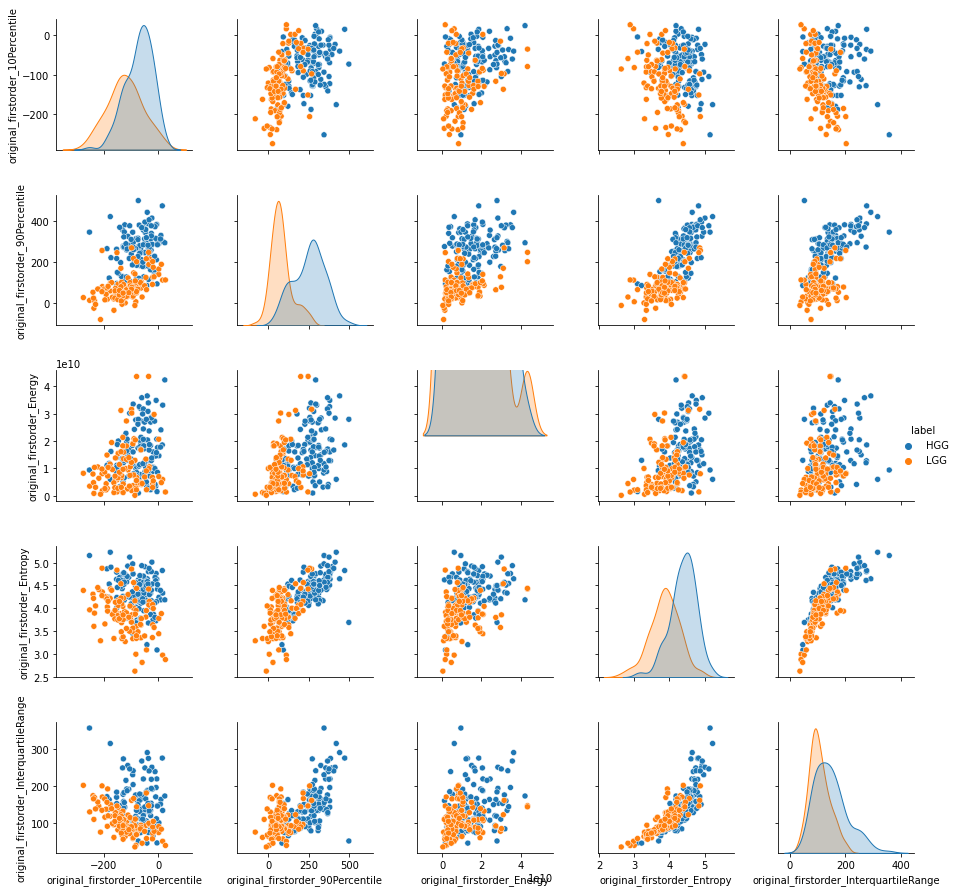

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter one sequence type and a segmentation type (you can change the sequence type and segmentation type)
d = data[(data['sequence']=='t1ce')  & (data['segmentation']=='full')].iloc[:, 3:9] 

sns.pairplot(d, hue="label", height=2.5, )
plt.tight_layout()
plt.show()

#### Interpretation
When observing the produced plots, it can be seen that some pairs of features seem te bring high value towards discrimintating between LGG (in orange) and HGG (in blue). For instance, the plot at the second line and first column between the features 10Percentile (10th percentile of image intensities) and 90Percentile (idem with 90th) seem to cluster both cancer subtypes into fuzzy clusters. Multiple lines could be drawn on the graph and would yield performance which is expected to outperform randomness. In these 2D plots, a line is equivalent to a hyperplane (i.e. a plane whose dimension is one less than the dimension of the vectorial space); in other words, any line draw on a 2D plot between two features can be seen as a linear function solution of the classification problem. A decision system can be extracted from a line itself obtained by interrogating the data such as in this plot, and would essentially classify an MRI based on a hyperplance of the projections of the images into a two-dimensional space of features (the space {10Percentile, 90Percentile}). Multi-dimensional machine learning such as linear functions on high dimensional feature spaces with more than 2 features essentially perform the same method, by trying to fit a hyperplance based on a training set such that the classes are separated as much as possible. It is notworthy that rigourous machine learning should involve a hold-out testing set such as to challenge any extracted rule, would it be a line between a space of 2 vectors or any parametrized algorithm such as artificial neural networks, on data samples which have not been used to extract such decision system.

### Plot features as a heatmap¶

Showing the pairwise join distributions may still be mind-boggling when we have a lot of variables in the dataset. Sometimes, we can just plot the correlation matrix to quantify the linear relationship between variables.

A heat map gives the correlation of features to each other, red indicating positive correlation, and blue negative one. A heatmap may be clustered to show groupings of features that are similar.

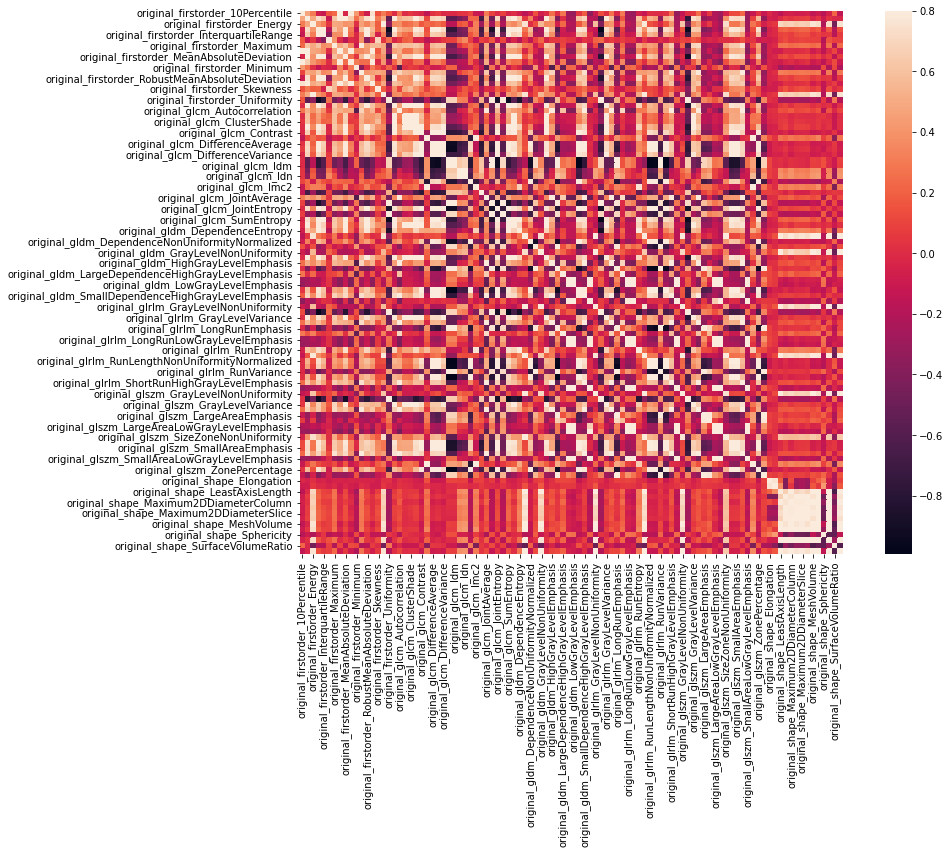

In [ ]:
import pandas as pd
import seaborn as sns

# filter one sequence type and a segmentation type (you can change the sequence type and segmentation type)
d = data[(data['sequence']=='t1ce')  & (data['segmentation']=='full')].iloc[:, 3:] # the full feature one is too big

# create the correlation matrix
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show();

### Cluster the heatmap

Though useful, heatmaps tell a much better story if the features are clustered. Here we will take a smaller subset of the features and cluster them. In this dendrogram, there are 2 major groups, and many smaller groupings.

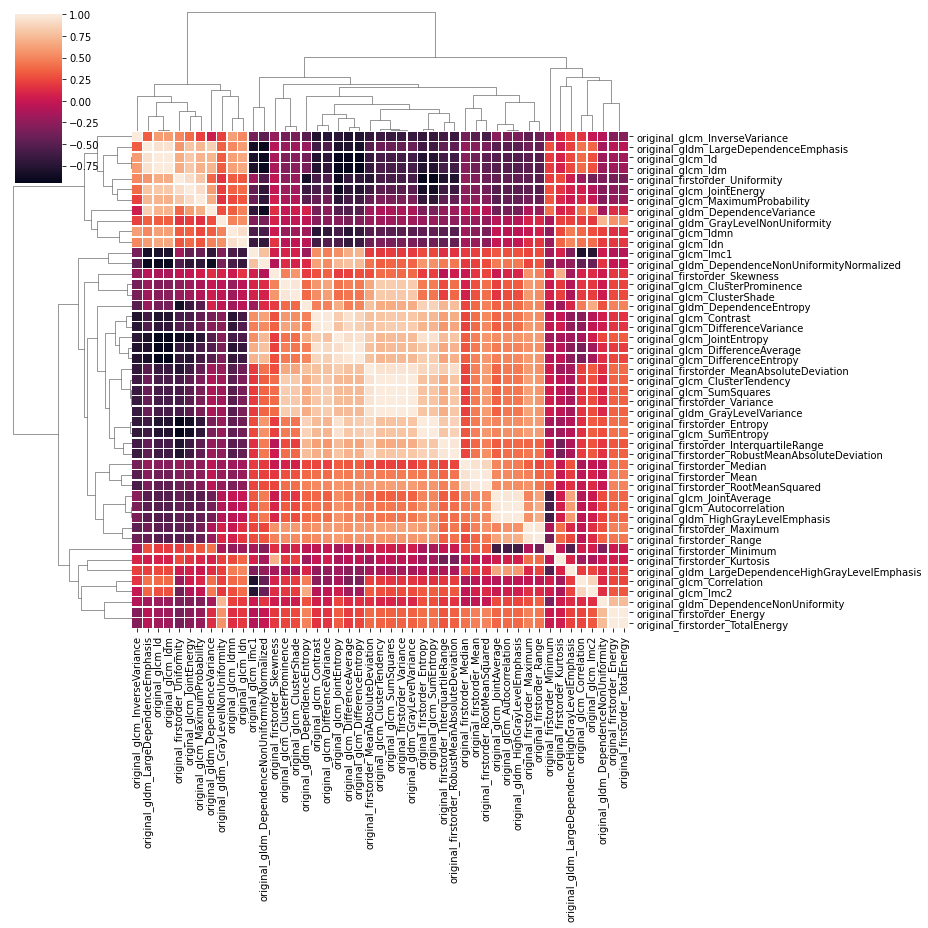

In [ ]:
# Choose a subset of features for clustering
dd = d.iloc[:,3:50]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show();